In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from pathlib import Path
from tqdm import tqdm
import cv2
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
 # Load a resnet from the model zoo
model = foz.load_zoo_model("resnet50-imagenet-torch")

# Verify that the model exposes embeddings
print(model.has_embeddings)

/home/khoa-ys/Projects/synthetic_data/fiftyone_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khoa-ys/Projects/synthetic_data/fiftyone_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True


In [4]:
chosen_class = ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Glioblastoma',
                'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma',
                'Schwannoma', 'Tuberculoma', '_NORMAL']

In [5]:
# Load data into fiftyone dataset
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "brain_tumor_44_classes")
image_list = [data_path + "/" + folder_name + "/" + fname 
                     for folder_name in os.listdir(data_path)
                     for fname in os.listdir(data_path+ "/" + folder_name)]
samples = []
cluster_labels = []
for folder_name in os.listdir(data_path):
    if folder_name.split(" ")[0] in chosen_class:
        for fname in os.listdir(data_path+ "/" + folder_name):
            file_path = data_path + "/" + folder_name + "/" + fname 
            sample = fo.Sample(filepath=file_path)
            sample["ground_truth"] = fo.Classification(label=folder_name)
            cluster_labels.append(folder_name)
            samples.append(sample)
dataset = fo.Dataset()
dataset.add_samples(samples)
print(dataset.first())
print(dataset.values)

"""
# Export dataset for future uses
dataset.export(
    export_dir='brain_tumor', dataset_type=fo.types.ImageDirectory
)
"""

dataset

 100% |███████████████| 4108/4108 [506.9ms elapsed, 0s remaining, 8.1K samples/s]      
<Sample: {
    'id': '643d50f2d20dcbff35573da6',
    'media_type': 'image',
    'filepath': '/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/brain_tumor_44_classes/Astrocitoma T1/005_big_gallery.jpeg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '643d50f2d20dcbff35572d99',
        'tags': BaseList([]),
        'label': 'Astrocitoma T1',
        'confidence': None,
        'logits': None,
    }>,
}>
<bound method SampleCollection.values of Name:        2023.04.17.17.00.18
Media type:  image
Num samples: 4108
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.co

Name:        2023.04.17.17.00.18
Media type:  image
Num samples: 4108
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)

In [6]:
# Compute embeddings from the images 
embeddings = dataset.compute_embeddings(model)
# Save embeddings for future uses
with open('embeddings.pickle', 'wb') as handle:
    pickle.dump({'img_list':image_list, 'embedding': embeddings}, handle, protocol=pickle.HIGHEST_PROTOCOL)
data = {'img_list':image_list, 'embedding': embeddings}
"""
# Load the saved embeddings
with open('embeddings.pickle', 'rb') as handle:
    data = pickle.load(handle)
embeddings = data["embedding"]
"""
embeddings.shape

 100% |███████████████| 4108/4108 [50.2s elapsed, 0s remaining, 77.7 samples/s]      


(4108, 2048)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


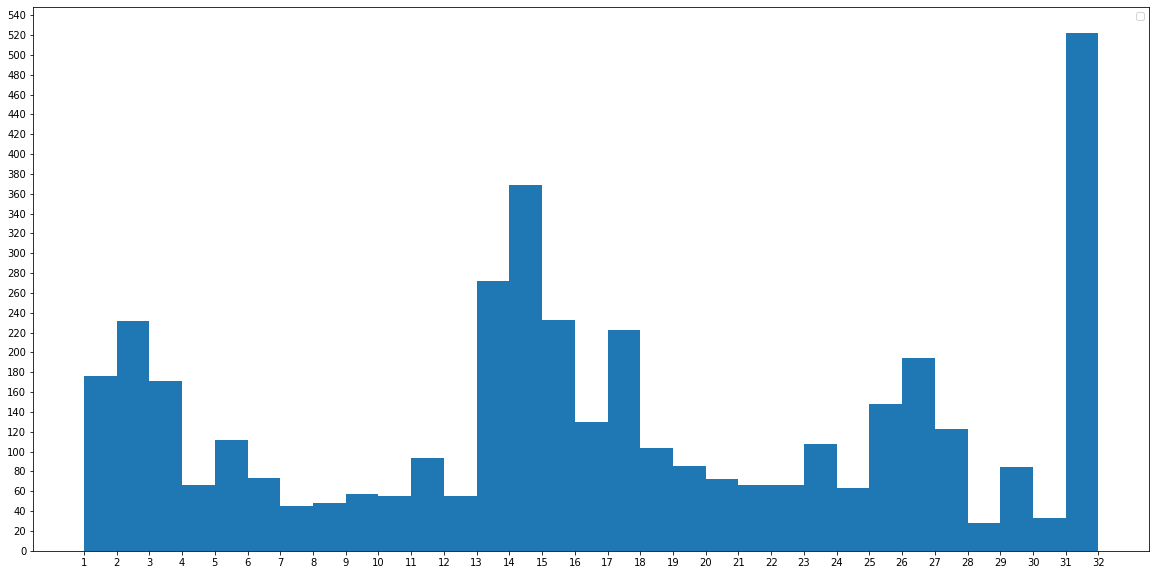

In [7]:
label_dict = dict(zip(np.unique(cluster_labels), range(1, len(cluster_labels)+2)))
modified_class = [label_dict[label] for label in cluster_labels]
plt.figure(figsize=(20, 10))
plt.hist(modified_class, bins=list(label_dict.values()))
plt.xticks(list(label_dict.values()))
plt.yticks(range(0, 551, 20))
plt.legend()
plt.show()

In [8]:
# Compute 2D representation using pre-computed embeddings
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="tsne",
    brain_key="image_embeddings",
    verbose=True,
    seed=51,
)
data['2d-embeddings'] = results.points

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4108 samples in 0.002s...
[t-SNE] Computed neighbors for 4108 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4108
[t-SNE] Computed conditional probabilities for sample 2000 / 4108
[t-SNE] Computed conditional probabilities for sample 3000 / 4108
[t-SNE] Computed conditional probabilities for sample 4000 / 4108
[t-SNE] Computed conditional probabilities for sample 4108 / 4108
[t-SNE] Mean sigma: 2.067109
[t-SNE] Computed conditional probabilities in 0.043s


/home/khoa-ys/Projects/synthetic_data/fiftyone_venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 76.6140976, gradient norm = 0.0091716 (50 iterations in 0.287s)
[t-SNE] Iteration 100: error = 77.6992493, gradient norm = 0.0038045 (50 iterations in 0.631s)
[t-SNE] Iteration 150: error = 77.8034210, gradient norm = 0.0013475 (50 iterations in 0.185s)
[t-SNE] Iteration 200: error = 77.7771912, gradient norm = 0.0007614 (50 iterations in 0.184s)
[t-SNE] Iteration 250: error = 77.7550125, gradient norm = 0.0007894 (50 iterations in 0.191s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.755013
[t-SNE] Iteration 300: error = 1.6478074, gradient norm = 0.0012426 (50 iterations in 0.172s)
[t-SNE] Iteration 350: error = 1.2075537, gradient norm = 0.0004929 (50 iterations in 0.182s)
[t-SNE] Iteration 400: error = 1.0356936, gradient norm = 0.0002828 (50 iterations in 0.330s)
[t-SNE] Iteration 450: error = 0.9507283, gradient norm = 0.0001963 (50 iterations in 0.203s)
[t-SNE] Iteration 500: error = 0.9040400, gradient norm = 0.0001509 (50 

In [9]:
session = fo.launch_app(dataset)
# Plot embeddings
plot = results.visualize(labels=cluster_labels)
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

FigureWidget({
    'data': [{'customdata': array(['643d50f2d20dcbff35573da6', '643d50f2d20dcbff35573da8',
    …